# Project 5: Machine Learning Modelling to Predict Deaths Associated with COVID-19

## Seung Woo Choi, Eric Rodriguez and Muhammad Tahir; Data Science Immersive @ General Assembly - March 2021

## Part 1: Imports and Reading Data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import missingno as msno
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn import metrics

import os
import glob

%matplotlib inline

In [2]:
# # code previously used to combine all CSV files h/t freecodecamp.org
# extension = 'csv'
# all_filenames = [i for i in glob.glob('*.{}'.format(extension))]
# #combine all files in the list
# combined_csv = pd.concat([pd.read_csv(f) for f in all_filenames ])
# #export to csv
# combined_csv.to_csv( "combined_csv.csv", index=False, encoding='utf-8-sig')

In [3]:
# importing combined CSV with all covid-19 data
df_all = pd.read_csv('../datasets/csse_covid_19_daily_reports_us/combined_csv.csv',
                 na_values=[''], keep_default_na=False)

In [4]:
df_all.shape

(19564, 20)

In [5]:
# creating data frame that contains only texas data
df_all_texas = df_all.loc[df_all['Province_State']=='Texas']

In [6]:
# creating data frame that contains only texas data in 2020
df_all_texas_2020 = df_all_texas[df_all_texas.Last_Update.str.contains("2020")]

In [7]:
# creating individual data frames for months july-december in 2020 
df1 = df_all_texas_2020[df_all_texas_2020.Last_Update.str.startswith('2020-07')]
df2 = df_all_texas_2020[df_all_texas_2020.Last_Update.str.startswith('2020-08')]
df3 = df_all_texas_2020[df_all_texas_2020.Last_Update.str.startswith('2020-09')]
df4 = df_all_texas_2020[df_all_texas_2020.Last_Update.str.startswith('2020-10')]
df5 = df_all_texas_2020[df_all_texas_2020.Last_Update.str.startswith('2020-11')]
df6 = df_all_texas_2020[df_all_texas_2020.Last_Update.str.startswith('2020-12')]

In [8]:
frames = [df1, df2, df3, df4, df5, df6]

In [9]:
# concatenating texas data frames july-december 2020 into one data frame
df_texas = pd.concat(frames)

In [10]:
# shape makes sense, 4months of 31 days + 2months of 30 days = 184
df_texas.shape

(184, 20)

In [11]:
# double checking to make sure the df_texas contains data from july-december
# df_texas['Last_Update'].unique()

## Part 2: Exploratory Data Analysis

In [12]:
# Rename column names
df_texas.columns = [column.lower() for column in df_texas.columns]

In [13]:
# Check missing values
df_texas.isnull().sum()

province_state            0
country_region            0
last_update               0
lat                       0
long_                     0
confirmed                 0
deaths                    0
recovered                 0
active                    0
fips                      0
incident_rate             0
people_tested            52
people_hospitalized     184
mortality_rate           52
uid                       0
iso3                      0
testing_rate              0
hospitalization_rate    184
total_test_results      132
case_fatality_ratio     132
dtype: int64

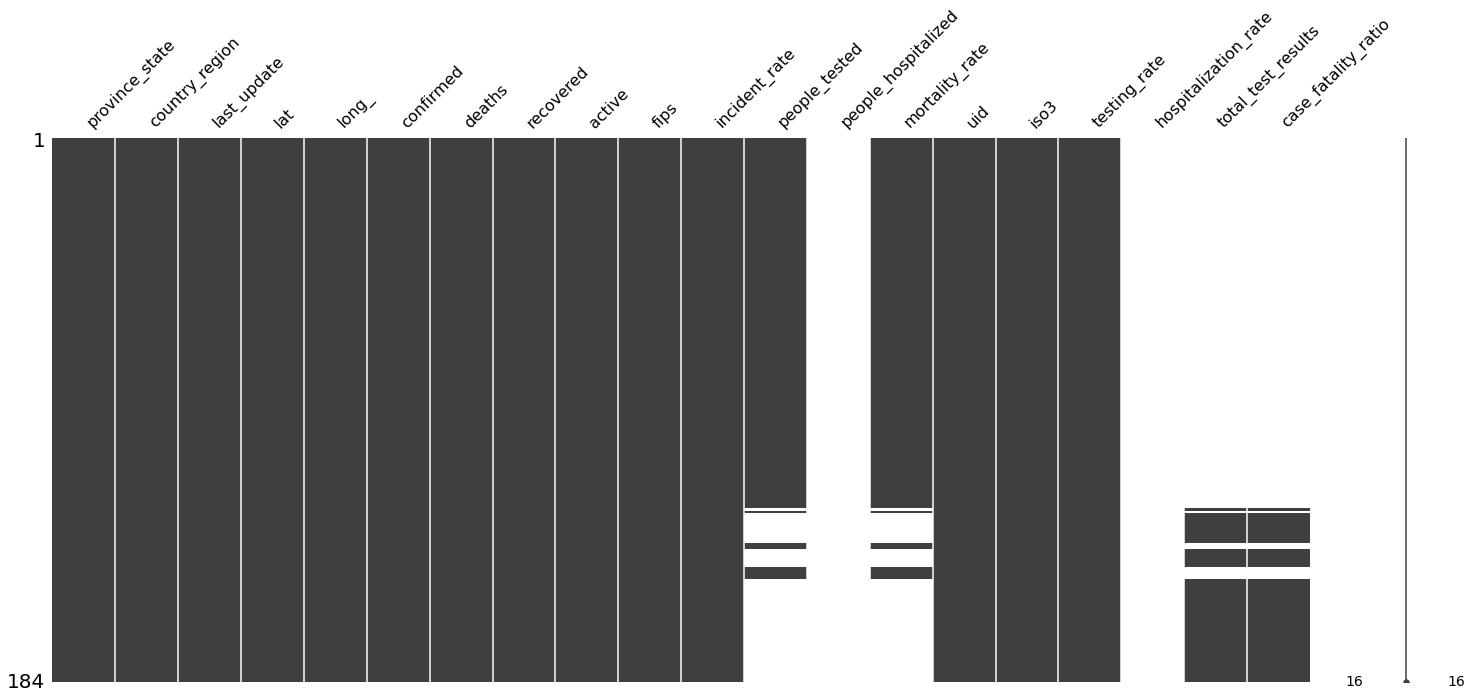

In [14]:
# Examine missing data
msno.matrix(df_texas);

In [15]:
# Drop 2 columns with 100% missing values: people_hospitalized and hospitalization_rate
df_texas = df_texas.drop(columns=['people_hospitalized', 'hospitalization_rate'])
df_texas.shape

(184, 18)

In [16]:
# Drop column: 'country_region', 'lat', 'long_', 'last_update', 'iso3'
df_texas = df_texas.drop(columns=['country_region', 'lat', 'long_', 'last_update', 'iso3'])

In [17]:
df_texas.columns

Index(['province_state', 'confirmed', 'deaths', 'recovered', 'active', 'fips',
       'incident_rate', 'people_tested', 'mortality_rate', 'uid',
       'testing_rate', 'total_test_results', 'case_fatality_ratio'],
      dtype='object')

#### Correlation matrix

<AxesSubplot:>

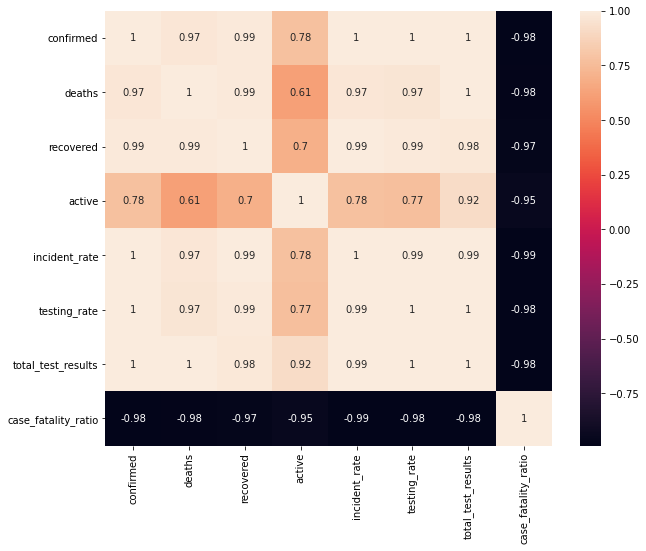

In [18]:
# heatmap to visualize correlation
plt.figure(figsize=(10,8))
sns.heatmap(df_texas.drop(columns=['fips', 'uid', 'people_tested', 'mortality_rate']).corr(), annot=True)

Several features appear to be strongly correlated with deaths, especially 'recovered'.

Case_fatality ratio is very negatively coorelated with all features

#### Scatterplots

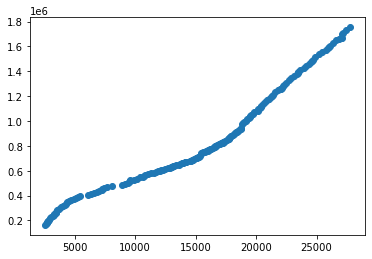

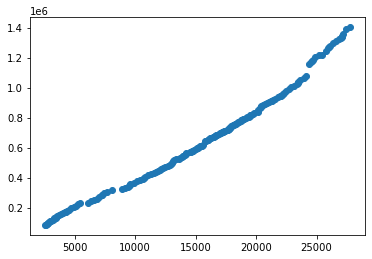

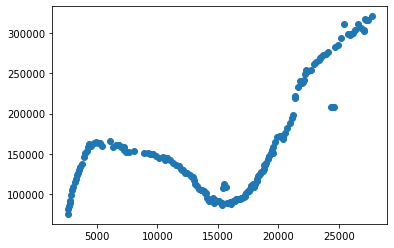

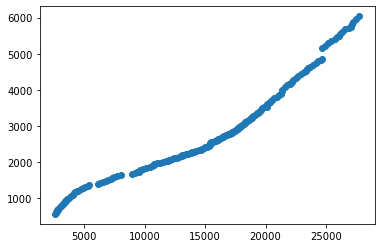

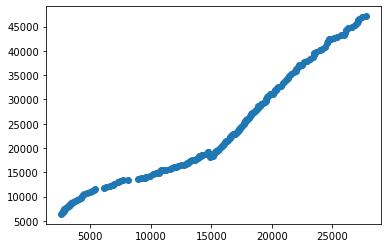

In [19]:
plt.scatter(df_texas['deaths'], df_texas['confirmed'])
plt.show();
plt.scatter(df_texas['deaths'], df_texas['recovered'])
plt.show();
plt.scatter(df_texas['deaths'], df_texas['active'])
plt.show();
plt.scatter(df_texas['deaths'], df_texas['incident_rate'])
plt.show();
plt.scatter(df_texas['deaths'], df_texas['testing_rate'])
plt.show();

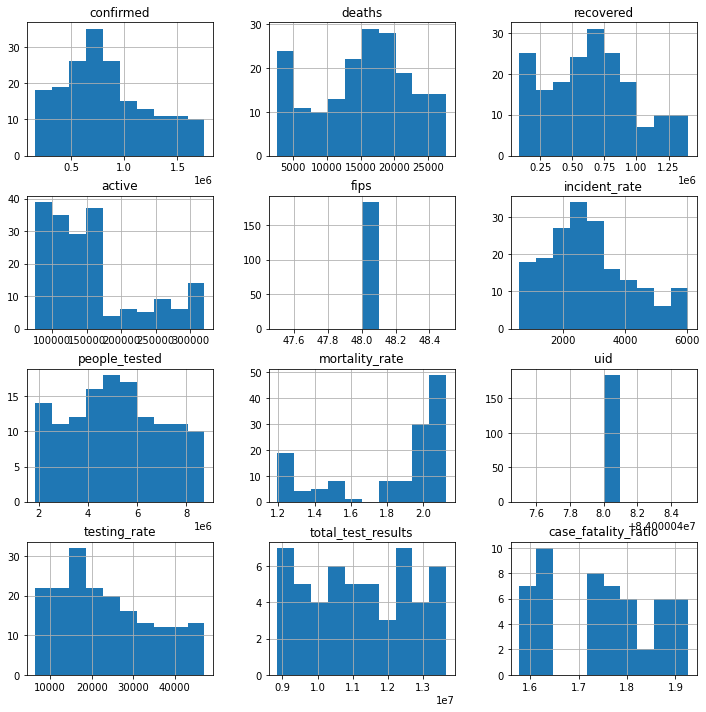

In [20]:
# histograms of numerical columns
df_texas.hist(figsize=(12, 12));

#### Boxplots

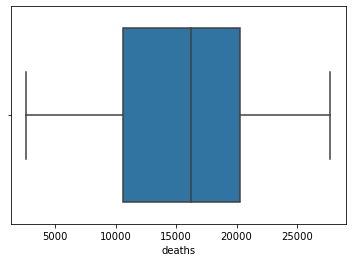

In [21]:
# boxplot visualizing the distribution of deaths
sns.boxplot(x = df_texas['deaths']);

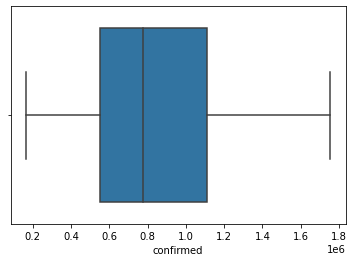

In [22]:
# boxplot visualizing the distribution of confirmed cases
sns.boxplot(x = df_texas['confirmed']);

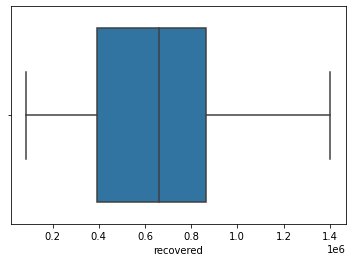

In [23]:
# boxplot visualizing the distribution of recovered caases
sns.boxplot(x = df_texas['recovered']);

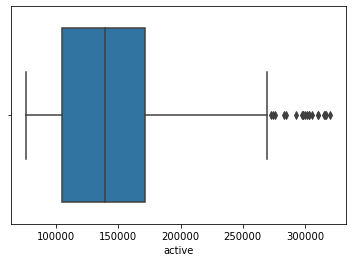

In [24]:
# boxplot visualizing the distribution of active COVID-19 cases
sns.boxplot(x = df_texas['active']);

Out of all of the boxplots, active cases seems to have the most outliers

In [25]:
# checking for missing values
df_texas.isnull().sum(0)

province_state           0
confirmed                0
deaths                   0
recovered                0
active                   0
fips                     0
incident_rate            0
people_tested           52
mortality_rate          52
uid                      0
testing_rate             0
total_test_results     132
case_fatality_ratio    132
dtype: int64

In [26]:
# dropped columns with missing values. could imputate people_tested/mortality_rate, but mortality rate
# feels like a give away considering deaths are our outcome of interest, and people_tested is associated with testing_rate
X = df_texas.drop(columns=['deaths', 'province_state', 
                     'fips', 'uid', 
                     'case_fatality_ratio', 'mortality_rate',
                     'people_tested', 'total_test_results']) 
y = df_texas['deaths']

In [27]:
X.head()

,confirmed,recovered,active,incident_rate,testing_rate
919,196377,100843.0,91461.0,672.274797,7357.793336
977,192796,97430.0,92116.0,662.690677,7145.183828
1499,429579,260542.0,161245.0,1476.861489,12448.230147
3183,263551,132638.0,126908.0,906.204574,8596.924508
3241,270707,136419.0,130083.0,930.401115,8760.295988


## Part 3: Model Testing

### Model 1: Null Model

In [28]:
# Mean deaths
df_texas['deaths'].mean()

15338.282608695652

In [29]:
# Define y
y = df_texas['deaths']

# Create a new column for the baseline target variable
df_texas['null_deaths'] = y.mean()

# Predictions for the null model
y_preds = df_texas['null_deaths']

# Null R-squared
metrics.r2_score(y, y_preds)

0.0

In [30]:
# Null RMSE
np.sqrt(metrics.mean_squared_error(y_true=y, y_pred=y_preds))

6936.424369142072

In [31]:
X = df_texas.drop(columns=['deaths', 'province_state', 
                     'fips', 'uid', 
                     'case_fatality_ratio', 'mortality_rate',
                     'people_tested', 'total_test_results',
                     'null_deaths']) # Removed null_deaths which was created for null model
y = df_texas['deaths']

In [32]:
X.columns

Index(['confirmed', 'recovered', 'active', 'incident_rate', 'testing_rate'], dtype='object')

## Model 2: Linear Regression

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
lr = LinearRegression()
sc = StandardScaler()
Z_train = sc.fit_transform(X_train)
Z_test = sc.transform(X_test)
lr.fit(Z_train, y_train)
lr.score(Z_train, y_train), lr.score(Z_test, y_test)

(0.995648370687546, 0.9985647799342895)

In [34]:
lr_preds = lr.predict(Z_test)
np.sqrt(metrics.mean_squared_error(y_train, lr.predict(Z_train))), np.sqrt(metrics.mean_squared_error(y_test, lr_preds))

(455.77076804228386, 261.2977834895292)

In [35]:
print(dict(zip(X.columns, lr.coef_)))

{'confirmed': 8564.794386975516, 'recovered': -172837.36429458947, 'active': -36192.85602805685, 'incident_rate': 199989.75864526758, 'testing_rate': -1648.3269803988628}


####  PCA

In [36]:
ss = StandardScaler()
Z_train = ss.fit_transform(X_train)
Z_test = ss.transform(X_test)

In [37]:
pca = PCA(n_components=2)
pca.fit(Z_train)
pca.transform(Z_train)

array([[-0.46053952, -0.82373981],
       [-1.88346391,  0.69502531],
       [-0.66966596, -0.79587146],
       [ 0.26554559, -0.6116212 ],
       [-1.24368686, -0.31623252],
       [ 4.46795539,  0.34761805],
       [-1.97931476,  0.88191016],
       [ 2.18691792,  0.34620792],
       [-1.31210834,  0.024653  ],
       [ 2.91307221, -0.47327827],
       [ 2.79758869,  0.52200795],
       [-1.10582306, -0.64628344],
       [ 2.12787395,  0.39173151],
       [-2.22549064,  1.04166957],
       [ 4.63627016,  0.51951168],
       [ 2.86688108,  0.53433048],
       [-0.55800274, -0.81453773],
       [-1.18127131, -0.52508232],
       [-1.70044275,  0.56763925],
       [ 1.17238881, -0.35524471],
       [-3.25401345,  0.441657  ],
       [-0.28265754, -0.76420011],
       [-0.32376117, -0.79030856],
       [-0.5366011 , -0.81746075],
       [-2.33891255,  1.02354331],
       [ 4.38816769,  0.51632932],
       [ 0.42044502, -0.5424636 ],
       [-2.08686765,  0.99762253],
       [-2.08221174,

In [38]:
var_exp = pca.explained_variance_ratio_
var_exp

array([0.92677181, 0.07150961])

In [39]:
cum_var_exp = np.cumsum(var_exp)
cum_var_exp

array([0.92677181, 0.99828142])

PCA model was ran to observe the predictive capability of our model.
Ultimately, PCA does not offer interpretability, so we did not proceed with PCA

## Model 3: Ridge Regression

In [40]:
# setting up ridge model and parameters
ridge_reg = Ridge()

params_ridge = {'alpha': [1,0.1,0.01,0.001,0.0001,0], 
                "fit_intercept": [True, False], 
                "solver": ['svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']}

In [41]:
# setting up X and y
X = df_texas.drop(columns=['deaths', 'province_state', 
                     'fips', 'uid', 
                     'case_fatality_ratio', 'mortality_rate',
                     'people_tested', 'total_test_results',
                     'null_deaths']) # Removed null_deaths which was created for null model
y = df_texas['deaths']

In [42]:
X.columns

Index(['confirmed', 'recovered', 'active', 'incident_rate', 'testing_rate'], dtype='object')

In [43]:
X.shape

(184, 5)

In [44]:
# train-test-split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [45]:
# performing our gridsearch
ridge_gs = GridSearchCV(ridge_reg, param_grid=params_ridge, n_jobs=-1)
ridge_gs.fit(X_train,y_train)
ridge_gs.best_params_

{'alpha': 0.01, 'fit_intercept': True, 'solver': 'lsqr'}

In [46]:
ridge_gs.best_score_

0.9904466613577471

In [47]:
# setting up ridge model with best paramters
ridge_reg = Ridge(alpha = 0.01, solver='lsqr')

In [48]:
# scaling the data
sc = StandardScaler()
Z_train = sc.fit_transform(X_train)
Z_test = sc.transform(X_test)

In [49]:
# fitting our data with the best paramters
ridge_reg.fit(Z_train, y_train)
ridge_reg.score(Z_train, y_train), ridge_reg.score(Z_test, y_test)

(0.9919204551916819, 0.9951482276773628)

In [50]:
# calculating predictions and RMSE
ridge_reg_preds = ridge_reg.predict(Z_test)
np.sqrt(metrics.mean_squared_error(y_train, ridge_reg.predict(Z_train))), np.sqrt(metrics.mean_squared_error(y_test, ridge_reg_preds))

(621.0319838224115, 480.42619969124365)

In [51]:
# evaluating coefficients
print(dict(zip(X.columns, ridge_reg.coef_)))

{'confirmed': 13189.337556497248, 'recovered': -1626.3541590637162, 'active': -2808.6466465176964, 'incident_rate': -39.721585080646264, 'testing_rate': -2615.8538740025433}


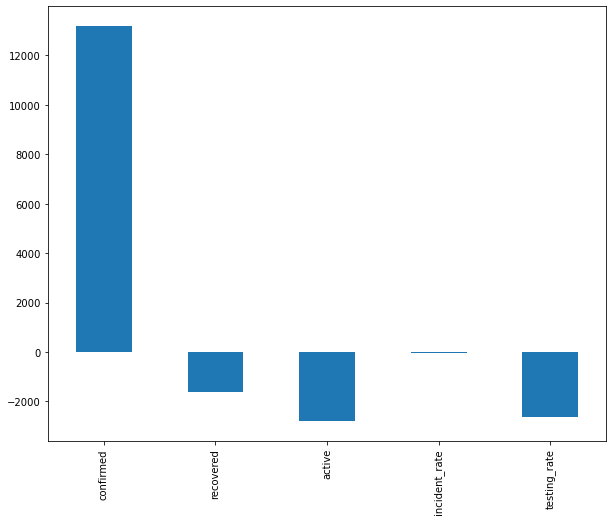

In [52]:
# visualizing coefficients
features = ['confirmed', 'recovered', 'active', 'incident_rate', 'testing_rate']
pd.Series(ridge_reg.coef_, index=features).plot.bar(figsize=(10, 8));

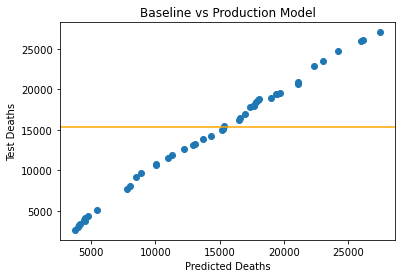

In [53]:
# comparing test values with model predicted values
plt.scatter(ridge_reg_preds, y_test)
plt.title('Baseline vs Production Model')
plt.ylabel('Test Deaths')
plt.xlabel('Predicted Deaths')
plt.axhline(df_texas['deaths'].mean(), color='orange');

**Interpretation:**
Our R-squared on unseen data is 99.5%, and our RMSE on unseen data is 480.43.

Because this model has the best values for our metrics of interest, we will use Ridge Regression as our production model

## Model 4: Lasso Regression

In [54]:
# setting up lasso model
lasso_reg = Lasso()

In [55]:
# grid search parameters
params_lasso = {'alpha': [1,0.1,0.01,0.001,0.0001,0], 
                "fit_intercept": [True, False], 
                "selection": ['cyclic', 'random']}

In [56]:
# setting up X and y
X = df_texas.drop(columns=['deaths', 'province_state', 
                     'fips', 'uid', 
                     'case_fatality_ratio', 'mortality_rate',
                     'people_tested', 'total_test_results',
                     'null_deaths']) # Removed null_deaths which was created for null model
y = df_texas['deaths']

In [57]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [58]:
# performing gridsearch on lasso model
lasso_gs = GridSearchCV(lasso_reg, param_grid=params_lasso, n_jobs=-1)
lasso_gs.fit(X_train,y_train)
lasso_gs.best_params_

/Users/ericrodriguez/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26678506.592079856, tolerance: 658749.2402492755
  model = cd_fast.enet_coordinate_descent(


{'alpha': 1, 'fit_intercept': True, 'selection': 'cyclic'}

In [59]:
lasso_gs.best_score_

0.991148026858958

In [60]:
# setting up lasso model with best parameters
lasso_reg = Lasso(alpha = 1, selection='cyclic')

In [61]:
# scaling the data
sc = StandardScaler()
Z_train = sc.fit_transform(X_train)
Z_test = sc.transform(X_test)

In [62]:
# fitting our data with the best parameters
lasso_reg.fit(Z_train, y_train)
lasso_reg.score(Z_train, y_train), lasso_reg.score(Z_test, y_test)

/Users/ericrodriguez/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14434975.644586597, tolerance: 658749.2402492755
  model = cd_fast.enet_coordinate_descent(


(0.991730792800147, 0.9948596502742885)

In [63]:
# calculating predictions and RMSE
lasso_reg_preds = lasso_reg.predict(Z_test)
np.sqrt(metrics.mean_squared_error(y_train, lasso_reg.predict(Z_train))), np.sqrt(metrics.mean_squared_error(y_test, lasso_reg_preds))

(628.2788751455306, 494.50741790818853)

In [64]:
# evaluating lasso model coefficients
print(dict(zip(X.columns, lasso_reg.coef_)))

{'confirmed': 10846.483542898146, 'recovered': -1250.8800740939073, 'active': -2730.2334714929148, 'incident_rate': 803.1091806971322, 'testing_rate': -1548.746569416119}


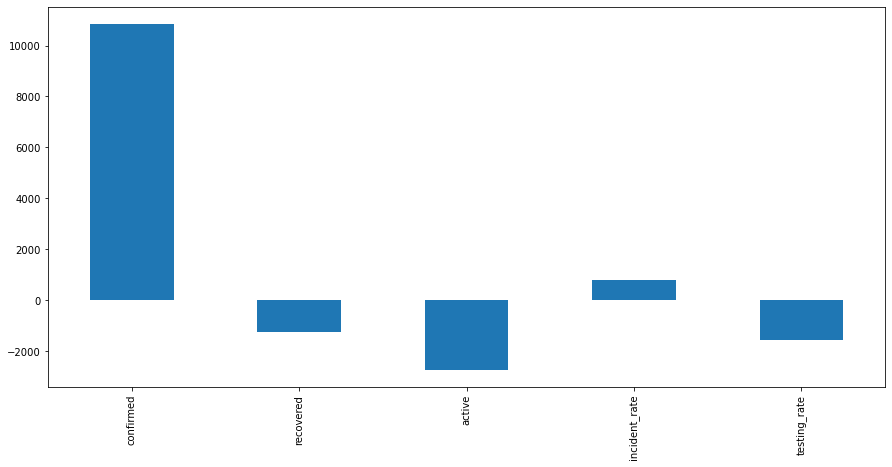

In [65]:
# visualizing coefficients
features = ['confirmed', 'recovered', 'active', 'incident_rate', 'testing_rate']
pd.Series(lasso_reg.coef_, index=features).plot.bar(figsize=(15, 7));

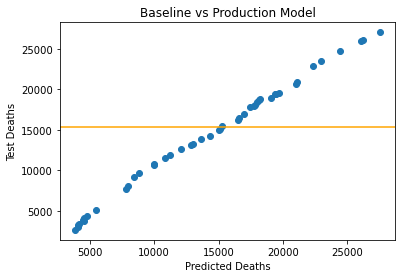

In [66]:
# comparing test values with model predicted values
plt.scatter(lasso_reg_preds, y_test)
plt.title('Baseline vs Production Model')
plt.ylabel('Test Deaths')
plt.xlabel('Predicted Deaths')
plt.axhline(df_texas['deaths'].mean(), color='orange');

**Interpretation:**
Our R-squared on unseen data is 99.5%, and our RMSE on unseen data is 494.51

## Future Steps

In [67]:
# importing combined CSV with all covid-19 data
df_all = pd.read_csv('../datasets/csse_covid_19_daily_reports_us/combined_csv.csv',
                 na_values=[''], keep_default_na=False)

# creating data frame that contains only texas data
df_all_texas = df_all.loc[df_all['Province_State']=='Texas']

# creating data frame that contains only texas data in 2020
df_all_texas_2020 = df_all_texas[df_all_texas.Last_Update.str.contains("2020")]

# creating individual data frames for months july-december in 2020 
df1 = df_all_texas_2020[df_all_texas_2020.Last_Update.str.startswith('2020-07')]
df2 = df_all_texas_2020[df_all_texas_2020.Last_Update.str.startswith('2020-08')]
df3 = df_all_texas_2020[df_all_texas_2020.Last_Update.str.startswith('2020-09')]
df4 = df_all_texas_2020[df_all_texas_2020.Last_Update.str.startswith('2020-10')]
df5 = df_all_texas_2020[df_all_texas_2020.Last_Update.str.startswith('2020-11')]
df6 = df_all_texas_2020[df_all_texas_2020.Last_Update.str.startswith('2020-12')]

frames = [df1, df2, df3, df4, df5, df6]

# concatenating texas data frames july-december 2020 into one data frame
df_texas = pd.concat(frames)

df_texas.head()

,Province_State,Country_Region,Last_Update,Lat,Long_,Confirmed,Deaths,Recovered,Active,FIPS,Incident_Rate,People_Tested,People_Hospitalized,Mortality_Rate,UID,ISO3,Testing_Rate,Hospitalization_Rate,Total_Test_Results,Case_Fatality_Ratio
919,Texas,US,2020-07-06 04:34:10,31.0545,-97.5635,196377,2817,100843.0,91461.0,48.0,672.274797,2133457.0,NaN,1.348162,84000048.0,USA,7357.793336,NaN,NaN,NaN
977,Texas,US,2020-07-05 04:34:00,31.0545,-97.5635,192796,2784,97430.0,92116.0,48.0,662.690677,2071809.0,NaN,1.356731,84000048.0,USA,7145.183828,NaN,NaN,NaN
1499,Texas,US,2020-07-31 04:35:31,31.0545,-97.5635,429579,6839,260542.0,161245.0,48.0,1476.861489,3609474.0,NaN,1.504335,84000048.0,USA,12448.230147,NaN,NaN,NaN
3183,Texas,US,2020-07-13 04:43:16,31.0545,-97.5635,263551,3432,132638.0,126908.0,48.0,906.204574,2492754.0,NaN,1.223921,84000048.0,USA,8596.924508,NaN,NaN,NaN
3241,Texas,US,2020-07-14 04:34:58,31.0545,-97.5635,270707,3505,136419.0,130083.0,48.0,930.401115,2540125.0,NaN,1.214332,84000048.0,USA,8760.295988,NaN,NaN,NaN


In [68]:
# changing date to datetime
df_texas['date'] = pd.to_datetime(df_texas['Last_Update'])

In [69]:
# setting the date as the ind
df_texas.set_index('date', inplace=True)
df_texas.sort_index(inplace=True)

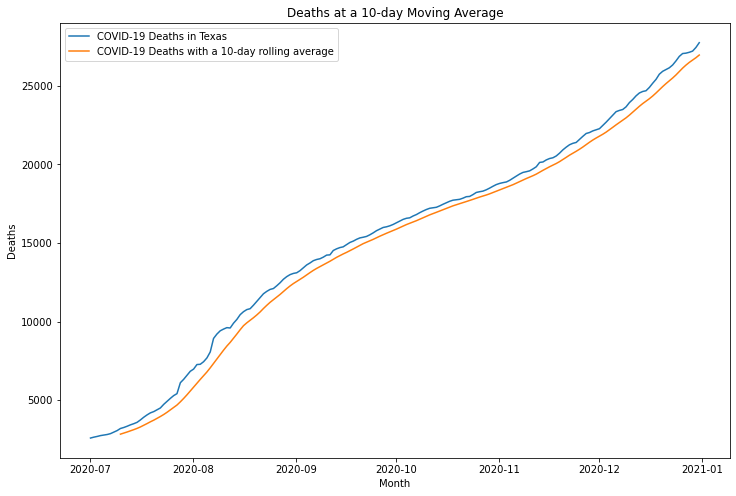

In [70]:
# plotting deaths and deaths with a rolling mean of 10
plt.figure(figsize=(12,8))
plt.plot(df_texas['Deaths'], label = 'COVID-19 Deaths in Texas')
plt.plot(df_texas['Deaths'].rolling(10).mean(), label = 'COVID-19 Deaths with a 10-day rolling average')
plt.legend()
plt.ylabel('Deaths')
plt.xlabel('Month')
plt.title('Deaths at a 10-day Moving Average');

Here we have visualized deaths, as well as deaths with a rolling mean of 10 days.
The rolling mean helps us visualize deaths without the deaths being as susceptible to spikes in the data or lags in data reporting.
Visualizing death as a function of time is the first step in time series modeling. From here, we want to try out several different time series forecasting techniques, but time did not permit us to do this.